# Import Dependencies

In [1]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import json
import random
import gc
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# Files
import os
from os.path import join, split
from glob import glob

# Torch
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, ReLU, ConvTranspose2d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.transforms import CenterCrop
import torch.nn.functional as F
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler

import tempfile
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import CPUOffload, wrap

In [2]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model

In [3]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = ReLU()
        self.conv2 = Conv2d(out_ch, out_ch, 3, padding=1)

        # init random weights
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels
        self.pool = MaxPool2d((2,2))

        self.encoder = nn.ModuleList([
            Block(channels[i], channels[i+1]) for i in range(len(channels)-1) # 1, 32, ..., 1024
        ])

    def forward(self, x):
        skip_out = []
        for block in self.encoder: # Goes through all blocks, passes through block and saves skip output
            x = block(x)
            skip_out.append(x)
            x = self.pool(x) # Reduces dim
        return skip_out

In [5]:
class AutoDecoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels[:0:-1] # Reverse of Encoder (Excluding First Unneeded in Output)
        self.pool = MaxPool2d((2,2))
        self.upconv = nn.ModuleList([
            ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2) for i in range(len(self.channels)-1)
        ])

        self.decoder = nn.ModuleList([
            Block(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)
        ])

    def center_crop(self, x, enc_out): # Crop encoder output
        _, _, h, w = x.shape
        enc_out = CenterCrop([h,w])(enc_out)
        return enc_out
    
    def forward(self, x, enc_out:list):
        for i in range(len(self.channels)-1):
            x = self.upconv[i](x)
            enc_ftrs = self.center_crop(x, enc_out[i]) # Crop Skip
            x = torch.cat([x, enc_ftrs], dim=1) # Concatenate Decoder and Skip
            x = self.decoder[i](x)

            # Min Max Scaling [0,1]
            x = (x-x.min())/(x.max()-x.min())
        return x


In [6]:
class UNET(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512)):
        super().__init__()

        # Encoder Path
        self.enc_path = AutoEncoder(channels)

        # Decoder Path
        self.dec_path = AutoDecoder(channels)

        self.out = Conv2d(channels[1], 1, 1)

        # init random weights
        nn.init.xavier_normal_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    
    def forward(self, x):
        skips = self.enc_path(x)
        x = self.dec_path(skips[::-1][0], skips[::-1][1:]) 
        # Reverse of enc_out = upward path of decoder 
        #  [0] -> 1024 output
        # [1:] -> All other skip outputs
        x = self.out(x)
        # x = F.interpolate(x, (512,512))
        x = F.sigmoid(x)

        return x

In [7]:
model = torch.load("Models\\baseline\\baseline_10.pt").to(CFG.device)
model

UNET(
  (enc_path): AutoEncoder(
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (encoder): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

# Inference

## Visualize Function

In [143]:
def inference(idx:int = None, thresh:float = 98):
    if not idx:
        idx = random.randint(0, len(os.listdir("Numpy Dataset\\test\images")))
    img = np.load(f"Numpy Dataset\\all\images\image_{idx}.npy")
    label = np.load(f"Numpy Dataset\\all\labels\image_{idx}.npy")

    inference_img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    result = model(inference_img)

    result = result.squeeze().detach().cpu().numpy()
    result = (result-result.min())/result.max()

    th = np.percentile(result.flatten(), thresh)
    result = result>th

    fig,ax = plt.subplots(1,4, figsize=(13,13))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Image")
    ax[1].imshow(result, cmap='inferno')
    ax[1].set_title("Prediction")
    ax[2].imshow(label, cmap='inferno')
    ax[2].set_title("Label")
    ax[3].imshow(label*result, cmap='inferno')
    ax[3].set_title("Accuracy")

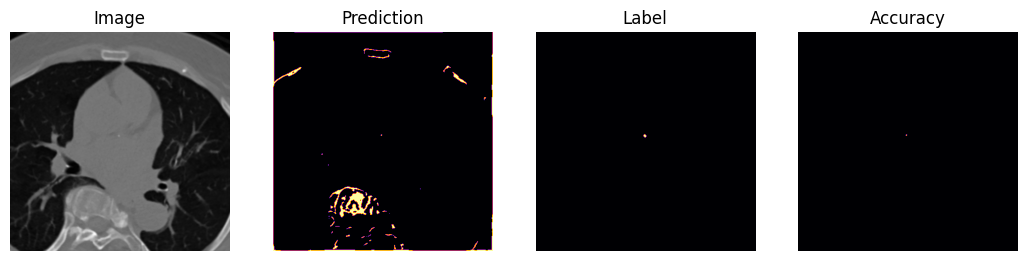

In [144]:
inference(88,97)